In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
device = 'cuda'

In [2]:
df = pd.read_csv('results.csv')
print(df.keys())
df['State'] = df[' State'].apply(lambda x:np.fromstring(x,sep=' '))
state_min = np.min(np.stack(df['State']),0)
state_max = np.max(np.stack(df['State']),0)
df['State'] = df['State'].apply(lambda x: (x-state_min)/(state_max-state_min+1e-9))
df['State'] = df['State'].apply(lambda x:torch.tensor(x).float())
one_hot = pd.get_dummies(df[' Action'])
df = df.join(one_hot)
df['State_'] = None
for i in range(len(df)-1):
    if str(df[' PrevActions'][i+1]) == str(df[' PrevActions'][i])+' '+str(df[' Action'][i]):
        df['State_'][i] = df['State'][i+1]
df = df.dropna()
df['Action'] = df.iloc[:,6:130].values.tolist()
df['Action'] = df['Action'].apply(lambda x: torch.tensor(x).float())
df['Reward'] = df[' Reward'].apply(lambda x: torch.tensor(x).float())
df.head()

Index(['BenchmarkName', ' State', ' Action', ' PrevActions', ' Reward'], dtype='object')


<ipython-input-2-271fb56b56f7>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['State_'][i] = df['State'][i+1]


,BenchmarkName,State,Action,PrevActions,Reward,State,-adce,-add-discriminators,-aggressive-instcombine,-alignment-from-assumptions,...,-speculative-execution,-sroa,-strip,-strip-dead-prototypes,-strip-debug-declare,-strip-nondebug,-tailcallelim,State_,Action,Reward
0,benchmark://poj104-v0/28_982,1414123.0 1559546.0 0.83 1607710.0 0.0 0.0 0.0...,-licm,-inferattrs -newgvn -gvn -sancov -lower-matrix...,-0.001756,"[tensor(0.0003), tensor(0.0184), tensor(0.0097...",0,0,0,0,...,0,0,0,0,0,0,0,"[tensor(0.0041), tensor(0.0094), tensor(0.0022...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",tensor(-0.0018)
1,benchmark://poj104-v0/28_982,1873342.0 1229633.0 0.56 1636593.0 0.0 0.0 0.0...,-tailcallelim,-inferattrs -newgvn -gvn -sancov -lower-matrix...,0.023496,"[tensor(0.0041), tensor(0.0094), tensor(0.0022...",0,0,0,0,...,0,0,0,0,0,0,1,"[tensor(0.0031), tensor(0.0037), tensor(0.0011...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",tensor(0.0235)
2,benchmark://poj104-v0/28_982,1749629.0 1022510.0 0.52 1620229.0 0.0 0.0 0.0...,-licm,-inferattrs -newgvn -gvn -sancov -lower-matrix...,-0.045576,"[tensor(0.0031), tensor(0.0037), tensor(0.0011...",0,0,0,0,...,0,0,0,0,0,0,0,"[tensor(0.0030), tensor(0.0055), tensor(0.0011...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",tensor(-0.0456)
3,benchmark://poj104-v0/28_982,1743849.0 1089621.0 0.52 1618324.0 0.0 0.0 0.0...,-elim-avail-extern,-inferattrs -newgvn -gvn -sancov -lower-matrix...,-0.054572,"[tensor(0.0030), tensor(0.0055), tensor(0.0011...",0,0,0,0,...,0,0,0,0,0,0,0,"[tensor(0.0036), tensor(0.0092), tensor(0.0017...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",tensor(-0.0546)
4,benchmark://poj104-v0/28_982,1812507.0 1222682.0 0.54 1609505.0 0.0 0.0 0.0...,-lower-matrix-intrinsics,-inferattrs -newgvn -gvn -sancov -lower-matrix...,-0.157990,"[tensor(0.0036), tensor(0.0092), tensor(0.0017...",0,0,0,0,...,0,0,0,0,0,0,0,"[tensor(0.0059), tensor(0.0120), tensor(0.0041...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....",tensor(-0.1580)


In [3]:
class experienceDataset(Dataset):
    def __init__(self,experience):
        self.experience = experience
    def __getitem__(self, i):
        # return S,A,R,S'
        return self.experience['State'].iloc[i].to(device),self.experience['Action'].iloc[i].to(device),self.experience['Reward'].iloc[i].to(device),self.experience['State_'].iloc[i].to(device),
    def __len__(self):
        return self.experience.shape[0]

In [4]:
class Q_net(nn.Module):
    def __init__(self,in_size,out_size,hidden_size,dropout):
        super(Q_net,self).__init__()
        self.l1 = nn.Linear(in_size,hidden_size)
        self.l2 = nn.Linear(hidden_size,hidden_size)
        self.l3 = nn.Linear(hidden_size,hidden_size)
        self.l4 = nn.Linear(hidden_size,hidden_size)
        self.l5 = nn.Linear(hidden_size,hidden_size)
        self.l6 = nn.Linear(hidden_size,hidden_size)
        self.l7 = nn.Linear(hidden_size,out_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = self.dropout(x)
        y = F.leaky_relu(self.l2(x))
        y = self.dropout(y)
        x = (x+y)*0.5
        x = F.leaky_relu(self.l3(x))
        x = self.dropout(x)
        y = F.leaky_relu(self.l4(x))
        y = self.dropout(y)
        x = (x+y)*0.5
        x = F.leaky_relu(self.l5(x))
        x = self.dropout(x)
        y = F.leaky_relu(self.l6(x))
        y = self.dropout(y)
        x = (x+y)*0.5
        return self.l7(x)

In [5]:
test_size = len(df) // 5
train_size = len(df) - test_size
experience = experienceDataset(df)
train_set, test_set = torch.utils.data.random_split(experience, [train_size, test_size])
batch_size = 1000
trainLoad = DataLoader(train_set,batch_size=batch_size,shuffle=True)
testLoad = DataLoader(test_set,batch_size=batch_size,shuffle=True)
policy_net = Q_net(28,124,512,0.5).to(device)
target_net = Q_net(28,124,512,0.5).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(policy_net.parameters())
train_losses = []
test_losses = []
num_epochs = 301
test_every = 5
gamma = 0.9

In [6]:
for epoch in range(num_epochs):
    loop_inner = tqdm(total=train_size//batch_size,position=0,leave=False)
    policy_net.train()
    for S,A,R,S_ in trainLoad:
        r = torch.sum(torch.mul(policy_net(S),A),1)
        r_hat = R + torch.max(target_net(S_),1).values*gamma
        
        loss = criterion(r,r_hat)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        loop_inner.set_description('epoch:{}, loss:{:.4f}'.format(epoch, loss.item()))
        loop_inner.update(1)
    loop_inner.close()
    if epoch % test_every == 0:
        with torch.no_grad():
            policy_net.eval()
            for S,A,R,S_ in trainLoad:
                r = torch.sum(torch.mul(policy_net(S),A),1)
                r_hat = R + torch.max(target_net(S_),1).values*gamma

                loss = criterion(r,r_hat)
                test_losses.append(loss.item())
    target_net.load_state_dict(policy_net.state_dict())

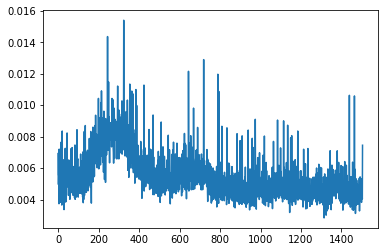

In [7]:
plt.plot(train_losses)

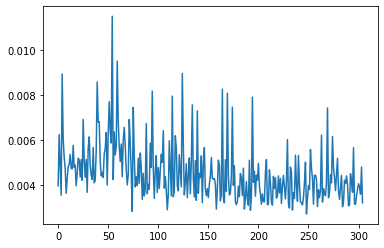

In [8]:
plt.plot(test_losses)

In [9]:
def get_action(state,network,epsilon):
    p = random.random()
    if p > epsilon:
        with torch.no_grad():
            return torch.max(network(state),1).indices[0].item()
    else:
        return random.randint(0,124)

In [12]:
get_action(df['State'].iloc[0],target_net,1)

123

In [16]:
get_action(df['State'].iloc[0].unsqueeze(0).to(device),target_net,0)

98

In [18]:
model_scripted = torch.jit.script(target_net) # Export to TorchScript
model_scripted.save('deep_q.pt') # Save